# Using the TDCOSMO likelihood with cobaya

Author: Natalie B. Hogg

## Installation

This notebook assumes that you have installed Cobaya as described here: https://cobaya.readthedocs.io/en/latest/installation.html, along with hierArc and lenstronomy.

## Sampling

Cobaya takes its settings either as Python dictionaries or in yaml format. Here are the yaml settings to do a very quick test run. Most of the parameters are kept fixed to arbitrary values.

In [2]:
info_yaml = r"""
likelihood:
    tdcosmo.tdcosmo.TDCOSMO:

theory:
    camb:
        stop_at_error: True
        extra_args:
            lens_potential_accuracy: 1

params:
  lambda_mst: 1.0
  lambda_mst_sigma: 0.01
  alpha_lambda: 0.0
  a_ani: 0.2
  a_ani_sigma: 0.05
  H0:
    prior:
        min: 0
        max: 150
    ref:
        dist: norm
        loc: 67
        scale: 2
    proposal: 2
    latex: H_0
  omegam:
    latex: \Omega_{\rm m}  
  w: -1.0
  wa: 0.0
  omegak: 0.0
  mnu: 0.06
  ombh2: 0.04
  
sampler:
    mcmc:
      Rminus1_stop: 1.0

output: chains/tdcosmo_tiny
force: True
"""

This will use the TDCOSMO likelihood with **just the TDCOSMO** dataset and use camb as the theory code to calculate angular diameter distances (in fact, the full theory is calculated including transfer functions). The basic MCMC sampler in Cobaya is used, and requested to stop sampling when the Gelman--Rubin criterion gets below 1.0. This is not sufficient for convergence, but is ok for a quick check.

The chains are written to the path given, and `force: True` overwrites previous products with the same path and name.

In [3]:
# import the yaml package
from cobaya.yaml import yaml_load

info = yaml_load(info_yaml)

In [4]:
# import the run package
from cobaya.run import run

# run the sampler with the above info
updated_info, sampler = run(info)

[output] Output to be read-from/written-into folder 'chains', with prefix 'tdcosmo_tiny'
[camb] `camb` module loaded successfully from /home/natalie/Projects/slide/cobaya_packages/code/CAMB/camb
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {tdcosmo.tdcosmo.TDCOSMO: 0.938, camb.transfers: 27.4, camb: 869.0}
[mcmc] Initial point: H0:67.16322
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2023-09-01 17:01:15 : 1 steps taken, and 0 accepted.
[mcmc] Progress @ 2023-09-01 17:02:17 : 57 steps taken, and 24 accepted.
[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 0.432
[mcmc]  - Convergence of means: R-1 = 0.425037 after 32 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2023

[root] *WARNING* outlier fraction 0.1 


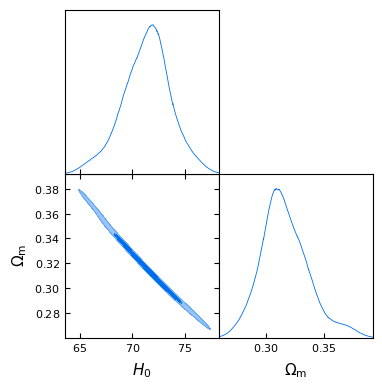

In [7]:
# import getdist to analyse the chain
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt
%matplotlib inline

# create the MCSamples object
gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])

# get the subplot plotter
gdplot = gdplt.getSubplotPlotter()

# choose some parameters to plot
gdplot.triangle_plot(gd_sample, ['H0', 'omegam'], filled=True)

We can see that the sampler runs and obtains reasonable contours, but convergence is evidently not reached. The sampling should be repeated with all the nuisance parameters sampled, and a smaller R-1 in place.